In [9]:
import nipype
import os,glob,sys,shutil
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
from IPython.display import Image

In [10]:
subjRootDir = "/data/HCP_Data/HCP_BedpostData/"

FULL_SUBJECT_LIST = [x for x in os.listdir(subjRootDir) if os.path.isdir( subjRootDir+x)]
print(len(FULL_SUBJECT_LIST),"Subjects are potentially available to be processed!")

899 Subjects are potentially available to be processed!


In [5]:
### Sample Subject = /HCP_Data/HCP_BedpostData/106016/T1w/Diffusion.bedpostX


In [11]:
SUBJECT_LIST = ['106016']

subject_id_infosource = pe.Node(util.IdentityInterface(fields=['subject_id']),
                                name='subject_id_infosource')
subject_id_infosource.iterables = ('subject_id', FULL_SUBJECT_LIST[40:120])

In [12]:
datasource = pe.Node(interface=nio.DataGrabber(infields=['subject_id'],
                                               outfields=['dwi', 'bvec', 'bval']),
                                                 name='datasource')
datasource.inputs.base_directory = subjRootDir 
datasource.inputs.sort_filelist = True
datasource.inputs.template = '%s/T1w/Diffusion/%s'
datasource.inputs.template_args = dict(dwi=[['subject_id', 'data.nii.gz']],
                                       bvecs=[['subject_id', 'bvecs']],
                                       bvals=[['subject_id', 'bvals']],
                                       nodif_brain_mask=[['subject_id','nodif_brain_mask.nii.gz']])
## Just mapped each subject to the corresponding bvec,bvals, brain mask and preprocessed DWI data
### Create the Node for DTIFIT
dtifit = pe.Node(interface=fsl.DTIFit(), name='dtifit')


gen_fa = pe.Workflow(name="gen_fa")
gen_fa.base_dir = '/data/HCP_Data/NipypeScratch/'
gen_fa.connect(subject_id_infosource, 'subject_id', datasource, 'subject_id')

gen_fa.connect(subject_id_infosource, 'subject_id', dtifit, 'base_name')
gen_fa.connect(datasource, 'bvecs', dtifit, 'bvecs')
gen_fa.connect(datasource, 'bvals', dtifit, 'bvals')
gen_fa.connect(datasource, 'nodif_brain_mask', dtifit, 'mask')
gen_fa.connect(datasource, 'dwi', dtifit, 'dwi')

180710-01:40:51,712 workflow INFO:
	 Generated workflow graph: /data/HCP_Data/NipypeScratch/gen_fa/graph.png (graph2use=colored, simple_form=False).
/data/HCP_Data/NipypeScratch/gen_fa/graph.png


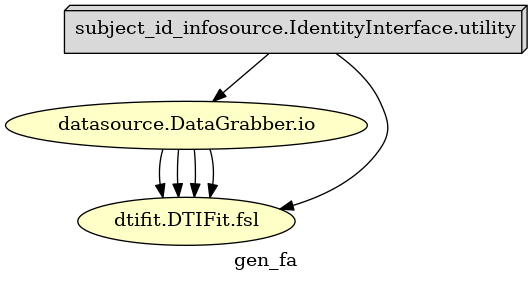

In [13]:
print(gen_fa.write_graph(graph2use='colored',simple_form=False))
Image('/data/HCP_Data/NipypeScratch/gen_fa/graph.png')
#Image('/data/HCP_Data/NipypeScratch/gen_fa/graph.png')

In [ ]:
gen_fa.run(plugin='MultiProc', plugin_args={'n_procs' : 20})


180710-01:40:54,333 workflow INFO:
	 Workflow gen_fa settings: ['check', 'execution', 'logging', 'monitoring']
180710-01:40:54,538 workflow INFO:
	 Running in parallel.
180710-01:40:54,548 workflow INFO:
	 [MultiProc] Running 0 tasks, and 80 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 20/20.
180710-01:40:54,628 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/HCP_Data/NipypeScratch/gen_fa/_subject_id_348545/datasource".
180710-01:40:54,630 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/HCP_Data/NipypeScratch/gen_fa/_subject_id_339847/datasource".
180710-01:40:54,633 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/HCP_Data/NipypeScratch/gen_fa/_subject_id_336841/datasource".
180710-01:40:54,636 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/HCP_Data/NipypeScratch/gen_fa/_subject_id_329440/datasource".
180710-01:40:54,639 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/HCP_Data/NipypeS

180710-01:40:56,602 workflow INFO:
	 [Job 38] Completed (gen_fa.datasource).
180710-01:40:56,606 workflow INFO:
	 [MultiProc] Running 0 tasks, and 80 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 20/20.
180710-01:40:56,665 workflow INFO:
	 [Node] Setting-up "gen_fa.dtifit" in "/data/HCP_Data/NipypeScratch/gen_fa/_subject_id_348545/dtifit".
180710-01:40:56,677 workflow INFO:
	 [Node] Setting-up "gen_fa.dtifit" in "/data/HCP_Data/NipypeScratch/gen_fa/_subject_id_339847/dtifit".
180710-01:40:56,680 workflow INFO:
	 [Node] Running "dtifit" ("nipype.interfaces.fsl.dti.DTIFit"), a CommandLine Interface with command:
dtifit -k /data/HCP_Data/HCP_BedpostData/348545/T1w/Diffusion/data.nii.gz -o 348545 -m /data/HCP_Data/HCP_BedpostData/348545/T1w/Diffusion/nodif_brain_mask.nii.gz -r /data/HCP_Data/HCP_BedpostData/348545/T1w/Diffusion/bvecs -b /data/HCP_Data/HCP_BedpostData/348545/T1w/Diffusion/bvals
180710-01:40:56,683 workflow INFO:
	 [Node] Setting-up "gen_fa.dtifit" in "/data/

In [18]:
#!ls /data/HCP_Data/HCP_BedpostData/106016/T1w/Diffusion/

bvals  bvecs  data.nii.gz  eddylogs  grad_dev.nii.gz  nodif_brain_mask.nii.gz


In [ ]:
datasink = pe.Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(os.path.abspath(working_data_dir),
                                              'sri_results')
datasink.inputs.parameterization = False
gen_fa.connect(dtifit, 'FA', datasink, 'FA')
gen_fa.connect(dtifit, 'MD', datasink, 'MD')